Give a brief description

# Research questions

1 Is there a significant correlation btw square footage and energy consumption?

2 Is the mean energy consumption of commercial buildings greater than 4000?

3 Is there a relationship between number of occupants and appliances used?

4 Does temperature affect energy consumption differently in different building types?

## Importing my libraries

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from summarytools import dfSummary
from scipy import stats
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

## Reading both my train and test data

In [3]:
energy_test_data = pd.read_csv("test_energy_data.csv")

In [4]:
energy_test_data

,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week,Energy Consumption
0,Residential,24563,15,4,28.52,Weekday,2865.57
1,Commercial,27583,56,23,23.07,Weekend,4283.80
2,Commercial,45313,4,44,33.56,Weekday,5067.83
3,Residential,41625,84,17,27.39,Weekend,4624.30
4,Residential,36720,58,47,17.08,Weekday,4820.59
...,...,...,...,...,...,...,...
95,Commercial,1161,81,11,15.45,Weekend,3010.81
96,Residential,37943,50,23,21.73,Weekend,4248.49
97,Commercial,1558,27,29,16.86,Weekend,2843.60
98,Industrial,2145,56,12,11.77,Weekend,3348.39


In [5]:
energy_train_data = pd.read_csv("train_energy_data.csv")

In [6]:
energy_train_data

,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week,Energy Consumption
0,Residential,7063,76,10,29.84,Weekday,2713.95
1,Commercial,44372,66,45,16.72,Weekday,5744.99
2,Industrial,19255,37,17,14.30,Weekend,4101.24
3,Residential,13265,14,41,32.82,Weekday,3009.14
4,Commercial,13375,26,18,11.92,Weekday,3279.17
...,...,...,...,...,...,...,...
995,Residential,14419,68,44,23.95,Weekend,3661.21
996,Industrial,12194,7,22,14.67,Weekend,3546.34
997,Commercial,39562,88,20,32.18,Weekday,5147.21
998,Residential,8348,67,37,16.48,Weekend,3244.98


# EDA

### Creating a pivot table 

In [7]:
## Total Energy Consumption by Building Type
df_train = pd.DataFrame(energy_train_data)
pivot = df_train.pivot_table(index='Building Type', values='Energy Consumption', aggfunc='sum')
print(pivot)

               Energy Consumption
Building Type                    
Commercial             1387687.92
Industrial             1501040.21
Residential            1277524.44


In [8]:
# Average Energy Consumption by Day of the Week
pivot = df_train.pivot_table(index='Day of Week', values='Energy Consumption', aggfunc='mean')
print(pivot)

             Energy Consumption
Day of Week                    
Weekday             4170.293491
Weekend             4162.096897


In [9]:
# Total Energy Consumption by Building Type and Day of the Week
pivot = df_train.pivot_table(index='Building Type', columns='Day of Week', values='Energy Consumption', aggfunc='sum')
print(pivot)

Day of Week      Weekday    Weekend
Building Type                      
Commercial     687487.31  700200.61
Industrial     745421.34  755618.87
Residential    681430.15  596094.29


In [10]:
dfSummary(energy_train_data, is_collapsible=False) 

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Building Type[object],1. Residential2. Commercial3. Industrial,347 (34.7%)336 (33.6%)317 (31.7%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlElEQVR4nO3bQWrCUBRG4ZsSpE4SguBiXEQX20VkNyK+gYqTdNCBdJ6el3c93wqucFAS/LtlWUIifNQ+QO+ji4h9ROxqH/IPnsuy3GsfoZf+cDh8DcMw1T5kbaWUS9d13wa3Hf0wDNPpdLqP4/iofcxartfr5zzP0/l83kWEsW1EHxExjuPjeDzeah+zsn3tA/SXDwjCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMMYmjLEJY2zCGJswfcTv/79qH7KmbJ8ni76UcpnneYpk//8qpVwi4ln7Dr24QRCmc8onSsZvNr/RNirduspV1XalWle5qtq2jOuqVE/VmfhSVxhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjEybVuirL58gq3brKVdV2uUEQxnWVMD4gCJPlZ9SfzgakmPI532tD81M+53vtyDLlS/HaJjsfEIQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGan/K1fPu7STHlc77XBjcIwjjlE+YHSryjSsNBJmwAAAAASUVORK5CYII="">",0(0.0%)
2,Square Footage[int64],Mean (sd) : 25462.4 (14294.6)min < med < max:560.0 < 25477.0 < 49997.0IQR (CV) : 24276.5 (1.8),986 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACYElEQVR4nO3dQYriQBiG4b/GVqJCggi68wIDs3DpIeawc4RZeAJv4E6QEDHTwRgzm5mBWXSrlcTk0/fZSlm1ePFPhYZ2ZVka0HVf2j4AcIu3tg+A5+GcG5rZwHP5qSzL948+JFTUwjk3nE6n38MwnPisPxwOsXPux0exEirqMgjDcLJard6jKMruWZgkSbBeryf7/X5gZoSK5kVRlM1ms18eS4effchlChL4RW1Ak5eKV0WoNWv6UvGqCLV+jV4qXlWnQ21zhFbYO7xcLv0oiuImLhXXPOtjR2dDbXOEVtk7z/OgKIqvWZb9NDOfUL0982NHZ0O1dkeo997b7Xay2WxG5/O557FvVU/72HE11LZHie97uaIoQjMLnXM+23qP7ziOK43uoij61sK5/6h09iZ9GqrqKEnTtJ/n+bfFYtHr9Xp3/bKYtTe+Vc/9CNd+USVHyel0eguCYLRcLrP5fB7fu76t8a167ke46Rm1zfHrs/Cv8Xjsde6q47sq1XM3qbHLFGMMdWosVMYY6tT46ynGGOrAX09BQpdf+OPB6niHW/OR/iFUmFn3L7+ECjPr/uWXUPGfrl5+uUxBAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCwk3/tDdJkuDeLz4ej4GZWZqmwW63Gz1yverequeuuv6Wvn4DP32yuuhfzykAAAAASUVORK5CYII="">",0(0.0%)
3,Number of Occupants[int64],Mean (sd) : 48.4 (29.1)min < med < max:1.0 < 47.0 < 99.0IQR (CV) : 51.2 (1.7),99 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACsUlEQVR4nO3dv27aUBSA8XMhROaPbCFU2Fg6VurgkYfow/YROvAEDF0ysSEhZIQbC2PcoWFLAd/LjX2c77efxMPnq8tBUUxZlgI0XafuBwDu8VT3A1xjjOmLyLPl+LEsy9dHPg/q09hQjTH9yWTyIwzDsc38fr/fGWN+Ems7NDZUEXkOw3C8WCxeoyjKqgwmSRIsl8vxdrt9FhFCbYEmhyoiIlEUZdPp9I/FaP/hD4Pa3AzV8Z7YEZGz5Wx4Pp97lrNomauhutwTi6LopWn6dTQavXQ6nbzqfJ7nQVEU37Is+yUiNicqWuTWiWp9T1yv1+PVavUljuPfs9lsV/XB3uYHp9OpW3VW5N+LIiKhMcZmXIStQaPcdUe1uSfudru+iMhwOLS6Y17mbaRp2svz/Pt8Pu92u91KL9jFZ9waOF7zRDy+3I3/MGXjeDw+BUEwiOM4sznNP+PWwHUdKOL35W5lqBe2p/mbWrYGNZ5q1tc8Ef8vd6tD1aYJp5rDOlDE48tNqM3S6FOtToTaQE091W5x3LRcvbIQass4xOL0BYvrpuXWlYVQ/8Pn6eCLSyyuX7C4bFruubIQ6jt8nw6+uMTi+gXLhcOm5eqVhVDf4ft08M0mFpcvWD4CoV7h63RAdfwpClQgVKhAqFCBO6oHde0y24xQH6zOXWabEeqDNWGX2UaE6kkbd5l14sMUVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSocNe/mEySJKj6gw+HQyAikqZpsNlsBh85r/V3a31u1/l7+voL4lazrdM0mtcAAAAASUVORK5CYII="">",0(0.0%)
4,Appliances Used[int64],Mean (sd) : 25.6 (14.1)min < med < max:1.0 < 26.0 < 49.0IQR (CV) : 25.0 (1.8),49 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACoElEQVR4nO3dP24iMRiH4c9LiByQZkSISMcFIm0RiYYDbLmH3SNsQbE1N6BDihAINiMmA1tlq4Q/Hibj3/A+LTJY6LUztiLh9vu9AbH7VvcEgFPc1D0BNIdz7s7MbgOHb/f7/etnLxIqLsI5d9fv938mSdILGb9arRbOuV+fxUqouJTbJEl64/H4NU3T7JyBy+XSTyaT3svLy62ZESqql6ZpNhgM/gYMvTv0IocpSGBHb

From the summary above, we can tell that our data has no missing values and duplicates 

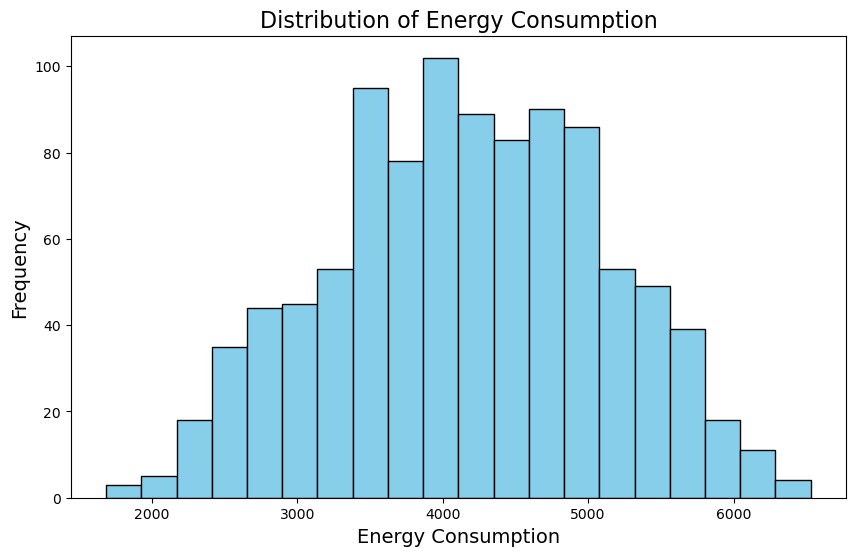

In [11]:
plt.figure(figsize=(10, 6))  # Adjusts the figure size
plt.hist(energy_train_data['Energy Consumption'], bins=20, color='skyblue', edgecolor='black')

# Adding labels and title
plt.title('Distribution of Energy Consumption', fontsize=16)
plt.xlabel('Energy Consumption', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

### Hypothesis Testing

Ho: The data is normally distributed

H1: The data is not normally distributed


Null Hypothesis (
𝐻
0): The data is normally distributed.

Alternative Hypothesis (
𝐻
1): The data is not normally distributed.

 If p-value > 0.05 → Fail to reject 
𝐻
0

​
 → Data is likely normal.
 
If p-value ≤ 0.05 → Reject 
𝐻
0
 
→ Data is not normal.

In [12]:
#Using Shapiro Wilk test(data less than 2000) to test for normality 
for column in energy_train_data.select_dtypes(include=['number']).columns:
    shapiro_test = stats.shapiro(energy_train_data[column].dropna())  # Drop NaNs to avoid errors
    print(f'Shapiro-Wilk Test for {column}:')
    print(f'Statistic = {shapiro_test.statistic:.4f}, p-value = {shapiro_test.pvalue:.4f}\n')

Shapiro-Wilk Test for Square Footage:
Statistic = 0.9564, p-value = 0.0000

Shapiro-Wilk Test for Number of Occupants:
Statistic = 0.9486, p-value = 0.0000

Shapiro-Wilk Test for Appliances Used:
Statistic = 0.9539, p-value = 0.0000

Shapiro-Wilk Test for Average Temperature:
Statistic = 0.9566, p-value = 0.0000

Shapiro-Wilk Test for Energy Consumption:
Statistic = 0.9935, p-value = 0.0002



Square Footage

Statistic: 0.9564, p-value: 0.0000
Interpretation: Since p-value < 0.05, not normally distributed.

Number of Occupants
Statistic: 0.9486, p-value: 0.0000
Interpretation: p-value < 0.05 → Not normally distributed.

Appliances Used
Statistic: 0.9539, p-value: 0.0000
Interpretation: p-value < 0.05 → Not normally distributed.

Average Temperature
Statistic: 0.9566, p-value: 0.0000
Interpretation: p-value < 0.05 → Not normally distributed.

Energy Consumption
Statistic: 0.9935, p-value: 0.0002
Interpretation: Although the statistic is close to 1 (indicating near-normal), p-value < 0.05 → Still not normally distributed.

Since our data is not normally distributed we use non - parametric test


lets come back and add	Test for normality using P-P plot. Q-Q plots and Shapiro

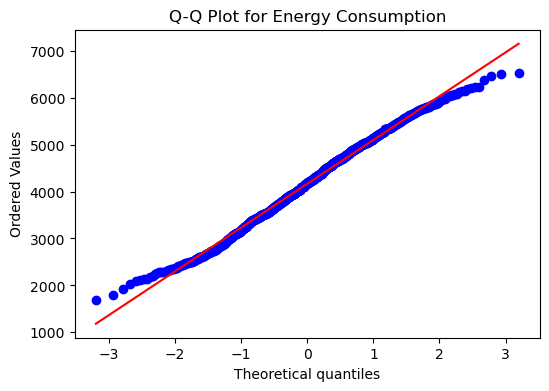

In [13]:
# Using Q-Q Plot to test for normality
plt.figure(figsize=(6, 4))
stats.probplot(energy_train_data[column].dropna(), dist="norm", plot=plt)
plt.title(f'Q-Q Plot for {column}')
plt.show()

The data is approximately normal in the middle range. and there are slight deviations at the extremes (tails) → There might be some skewness or outliers in the dataset.

 ###  Is there a significant correlation btw square footage and energy consumption?

To check if there is a significant correlation between square footage and energy consumption, especially when the data is not normally distributed, we can consider using correlation measures that do not assume normality.Since my data is not normally distributed, the Spearman Rank correlation is a good choice. It's a non-parametric measure, meaning it doesn't rely on any assumptions about the data distribution. It measures the strength and direction of the relationship between two variables by assessing how well the relationship between them can be described using a monotonic function (i.e., a function that either never decreases or never increases).

In [14]:
square_footage = energy_train_data['Square Footage']
energy_consumption = energy_train_data['Energy Consumption']

# Compute Spearman's correlation
corr, p_value = spearmanr(square_footage, energy_consumption)

# Print results
print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a statistically significant relationship between the number of occupants and appliances used.")
else:
    print("There is no significant relationship between the number of occupants and appliances used.")

Spearman correlation: 0.7816080764356164
P-value: 8.776577733464383e-207
There is a statistically significant relationship between the number of occupants and appliances used.


A Spearman correlation of 0.7816 indicates a strong positive correlation between square footage and energy consumption in your data.as square footage increases, energy consumption also tends to increase in a strong and positive manner. The correlation is quite high, but not perfect, meaning there's a general trend but not an exact one-to-one relationship.

## Visualizing the Relationship

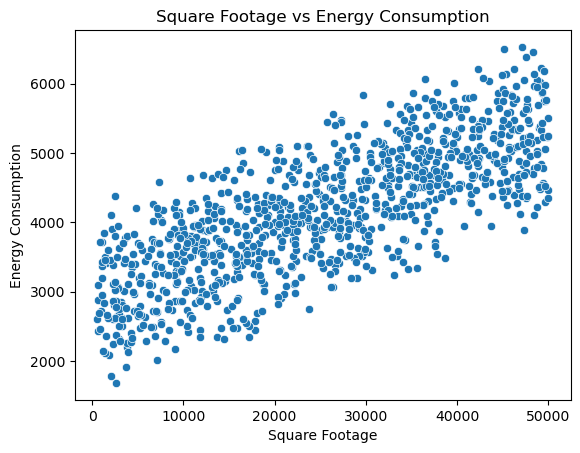

In [15]:
# Scatter plot to visualize the relationship
sns.scatterplot(x='Square Footage', y='Energy Consumption', data = energy_train_data)
plt.title("Square Footage vs Energy Consumption")
plt.xlabel("Square Footage")
plt.ylabel("Energy Consumption")
plt.show()

## Is the mean energy consumption of commercial buildings greater than 4000?

In [16]:
#use the the sign test for more than 4000

In [17]:
occupants = energy_train_data['Number of Occupants']
appliances = energy_train_data['Appliances Used']

# Compute Spearman's correlation
corr, p_value = spearmanr(occupants, appliances)

# Print results
print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a statistically significant relationship between the number of occupants and appliances used.")
else:
    print("There is no significant relationship between the number of occupants and appliances used.")

Spearman correlation: 0.024896201429206528
P-value: 0.43161899081346955
There is no significant relationship between the number of occupants and appliances used.


##  Is there a relationship between number of occupants and appliances used?

Visualizing the relationship between Temperature and Energy Consumption for each Building Type.

C:\Users\S P E C T R E\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


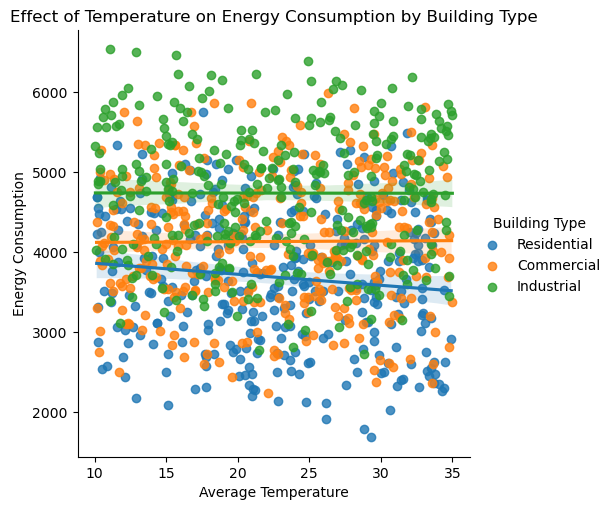

In [18]:
sns.lmplot(x = "Average Temperature", y = "Energy Consumption", hue = "Building Type", data = energy_train_data)
plt.title("Effect of Temperature on Energy Consumption by Building Type")
plt.xlabel("Average Temperature")
plt.ylabel("Energy Consumption")
plt.show()

Observations from the Scatterplot

Flat Trend Lines: The regression lines for all three building types (Residential, Commercial, and Industrial) appear relatively flat, suggesting that temperature might not have a strong effect on energy consumption.

Higher Energy Consumption in Industrial Buildings: The Industrial buildings (green) generally have higher energy consumption than Residential (blue) and Commercial (orange).

Residential Buildings Show a Slight Decline: The regression line for Residential buildings appears to slightly decrease as temperature increases, which might suggest lower energy consumption at higher temperatures

##Using  Kruskal-Wallis test to test whether there are significant differences in energy consumption distributions across Residential, Commercial, and Industrial buildings.

In [19]:
residential = energy_train_data[energy_train_data["Building Type"] == "Residential"]["Energy Consumption"]
commercial = energy_train_data[energy_train_data["Building Type"] == "Commercial"]["Energy Consumption"]
industrial = energy_train_data[energy_train_data["Building Type"] == "Industrial"]["Energy Consumption"]

# Perform Kruskal-Wallis test
stat, p_value = stats.kruskal(residential, commercial, industrial)

# Display results
print(f"Kruskal-Wallis Test Statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
alpha = 0.05  # Significance level
if p_value < alpha:
    print("There is a significant difference in energy consumption across building types.")
else:
    print("No significant difference in energy consumption across building types.")

Kruskal-Wallis Test Statistic: 197.2169
P-value: 0.0000
There is a significant difference in energy consumption across building types.


## Preprocessing my data

In [20]:
#Train data 
# Define target variable
y = energy_train_data['Energy Consumption']

# Define features (Drop target column)
X = energy_train_data.drop(columns=['Energy Consumption'])

categorical_cols = ['Building Type', 'Day of Week']  # Categorical features
numerical_cols = ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature']  # Numerical features

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encode categorical features
    ]
)

# Apply transformations (ONLY to features)
X_transformed = preprocessor.fit_transform(X)

# Convert transformed data to DataFrame
X_transformed = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())

# Print transformed features
print(X_transformed.head())


   num__Square Footage  num__Number of Occupants  num__Appliances Used  \
0            -1.287805                  0.951134             -1.106957   
1             1.323516                  0.606869              1.375645   
2            -0.434466                 -0.391498             -0.610436   
3            -0.853716                 -1.183306              1.091919   
4            -0.846017                 -0.770188             -0.539505   

   num__Average Temperature  cat__Building Type_Commercial  \
0                  1.012925                            0.0   
1                 -0.825544                            1.0   
2                 -1.164652                            0.0   
3                  1.430504                            0.0   
4                 -1.498155                            1.0   

   cat__Building Type_Industrial  cat__Building Type_Residential  \
0                            0.0                             1.0   
1                            0.0              

In [21]:
#Test data
#Train data 
# Define target variable
#y = energy_test_data['Energy Consumption']

# Define features (Drop target column)
#X =energy_test_data.drop(columns=['Energy Consumption'])

#categorical_cols = ['Building Type', 'Day of Week']  # Categorical features
#numerical_cols = ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature']  # Numerical features

# Define the ColumnTransformer
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', StandardScaler(), numerical_cols),  # Scale numerical features
#        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encode categorical features
#    ]
#)

# Apply transformations (ONLY to features)
#X_transformed = preprocessor.fit_transform(X)

# Convert transformed data to DataFrame
#X_transformed = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())

# Print transformed features
#print(X_transformed.head())


In [22]:
#Renaming columns because there are spaces

In [23]:
# energy_train_data_encoded.columns = energy_train_data_encoded.columns.str.replace(" ", "_")

In [24]:
#energy_train_data_encoded.columns

## Performing Feature Engineering

## Check for Multicollinearity Using Variance Inflation Factor (VIF)

In [25]:
print(X_transformed.columns)

Index(['num__Square Footage', 'num__Number of Occupants',
       'num__Appliances Used', 'num__Average Temperature',
       'cat__Building Type_Commercial', 'cat__Building Type_Industrial',
       'cat__Building Type_Residential', 'cat__Day of Week_Weekday',
       'cat__Day of Week_Weekend'],
      dtype='object')


In [26]:
# Extract transformed numerical feature names
num_feature_names = [col for col in X_transformed.columns if col.startswith('num__')]

# Select only numerical features
X_numerical = X_transformed[num_feature_names]

vif_data = pd.DataFrame()
vif_data["Feature"] = X_numerical.columns
vif_data["VIF"] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]

# Print VIF results
print(vif_data)

                    Feature       VIF
0       num__Square Footage  1.001995
1  num__Number of Occupants  1.001916
2      num__Appliances Used  1.004735
3  num__Average Temperature  1.004892


All the VIF values are close to 1, which indicates no multicollinearity among these features.

### Trying Linear Regression model (because the relationship between the input features and energy consumption is linear )

In [27]:
# Now that our data is clean, we can build our model with the train set 
# and keep the test set as our unseen data

# Prepare target variable (y) and features (X)
y = energy_train_data['Energy Consumption']
X = X_transformed  # The transformed features

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the model using OLS (Ordinary Least Squares)
model = sm.OLS(y, X)  # OLS model is the multiple linear regression model
results = model.fit()  # Fit the model to the data

# Print the summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     Energy Consumption   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.619e+11
Date:                Fri, 14 Feb 2025   Prob (F-statistic):               0.00
Time:                        12:15:39   Log-Likelihood:                 2875.1
No. Observations:                1000   AIC:                            -5734.
Df Residuals:                     992   BIC:                            -5695.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

## Checking if the residuals are normally distributed, with a Q-Q plot

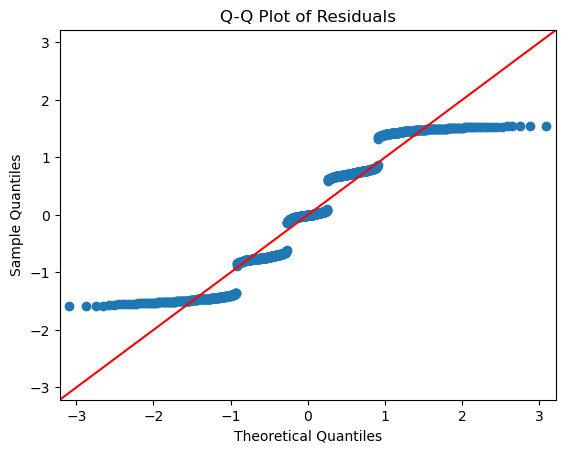

In [28]:
# Get the residuals from the model
residuals = results.resid  

# Create a Q-Q plot
sm.qqplot(residuals, line='45', fit=True)

# Show the plot
plt.title("Q-Q Plot of Residuals")
plt.show()

In [29]:
# Make predictions on the training data using the model
lr_preds = results.predict(X)  

# Calculate RMSE
lr_rmse = np.sqrt(mean_squared_error(y, lr_preds))

# Print RMSE value
print(f"Linear Regression RMSE: {lr_rmse:.4f}") 

Linear Regression RMSE: 0.0136
